In [36]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import sys
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, lognorm

In [3]:
DATA_SUITES = (
    'uf20-71R',
    'uf20-81R',
    'uf20-91R',
    'uf50-218R',
    'uf75-325',
    'ruf20-91R',
    'ruf50-218R',
    'ruf75-320R',
    '5uf20-420',
    '5uf50-1050',
    '7uf20-1760',
)

max_iterations = 500

#directory = 'gdrive/MyDrive/Colab Notebooks/KOP/output/uf20-71R'
#directory = 'gdrive/MyDrive/Colab Notebooks/KOP/output/5uf50-1050'
#directory = 'gdrive/MyDrive/Colab Notebooks/KOP/output/7uf20-1760'
#directory = 'gdrive/MyDrive/Colab Notebooks/KOP/output/ruf75-320R'

def load_datasets(suite, directory='gdrive/MyDrive/Colab Notebooks/KOP/output'):
  gsat = pd.read_csv(f'{directory}/{suite}/gsat.csv')
  probsat = pd.read_csv(f'{directory}/{suite}/probsat.csv').rename(columns={'flips': 'iterations'})
  return gsat, probsat

#gsat, probsat = load_datasets(DATA_SUITES[9])
gsat, probsat = load_datasets(DATA_SUITES[3])

In [4]:
def count_successes(df):
  return df['success'].sum()

In [5]:
def number_od_runs(df):
  return df.shape[0]

In [6]:
def success_ratio(df):
  return count_successes(df) / number_od_runs(df)

In [7]:
def average_iterations(df):
  return df['iterations'].mean()

In [8]:
def success_runs(df):
  return df[df['success'] == True]

In [9]:
def failed_runs(df):
  return df[df['success'] != True]

In [10]:
def average_fined_iterations(df):
  max = df['iterations'].max()
  df = df.copy()
  df['fine'] = (1 - df['success']) * max;
  df['iterations'] += df['fine']
  return average_iterations(df)

In [11]:
def lognormal_mu(df):
  return df['iterations'].replace(0, sys.float_info.min).apply(np.log).sum() / number_od_runs(df);

def lognormal_var(df):
  mu = lognormal_mu(df);
  return df['iterations'].replace(0, sys.float_info.min).apply(lambda x: (np.log(x) - mu) ** 2).sum() / (number_od_runs(df) - 1);

def lognormal_sigma(df):
  return math.sqrt(lognormal_var(df));

In [12]:
def cdf(df):
  iterations = df['iterations'].sort_values(ignore_index=True)
  numerator = 0
  denominator = len(iterations)
  cdf = [0]
  for i in range(max_iterations + 1):
    for j in range(numerator, denominator):
      if iterations[j] > i:
        break
      numerator += 1
    cdf.append(numerator / denominator)
  return cdf

def revcdf(cdf, coefficient):
  return [coefficient * y for y in cdf];


In [13]:
def pdf(df):
  iterations = df['iterations'].sort_values(ignore_index=True)
  denominator = len(iterations)
  return [x / denominator for x in iterations]

In [14]:
def xings(cdfa, cdfb):
  lastcdfa = 0
  lastcdfb = 0
  xings = []
  winner = 0
  for i in range(len(cdfa)):
    currentcdfa = cdfa[i]
    currentcdfb = cdfb[i]
    if lastcdfa < lastcdfb and currentcdfa > currentcdfb:
      xings.append(i)
      winner = 1
    elif lastcdfa > lastcdfb and currentcdfa < currentcdfb:
      xings.append(i)
      winner = 2
    lastcdfa = currentcdfa
    lastcdfb = currentcdfb
  if len(xings) == 0:
    if lastcdfa == 1:
      winner = 1 if cdfa[-2] > cdfb[-2] else 2
    else:
      winner = 1 if lastcdfa > lastcdfb else 2
  return xings, winner

In [15]:
print('success_ratio =', success_ratio(gsat))
print('average_iterations =', average_iterations(gsat))
print('average_fined_iterations =', average_fined_iterations(gsat))
print('lognormal_mu =', lognormal_mu(gsat))
print('lognormal_var =', lognormal_var(gsat))
cdf_gsat = cdf(gsat)
print('cdf =', len(cdf_gsat), cdf_gsat[:3], cdf_gsat[-3:])
revcdf_gsat = revcdf(cdf_gsat, success_ratio(gsat))
print('revcdf = ', len(revcdf_gsat), revcdf_gsat[:3], revcdf_gsat[-3:])

success_ratio = 0.49718
average_iterations = 345.9928
average_fined_iterations = 597.4028
lognormal_mu = 5.596161157380427
lognormal_var = 0.702804600288486
cdf = 502 [0, 0.0, 0.0] [0.49644, 0.49679, 1.0]
revcdf =  502 [0.0, 0.0, 0.0] [0.2468200392, 0.2469940522, 0.49718]


In [16]:
success_cdf_gsat = cdf(success_runs(gsat))
print('cdf =', len(success_cdf_gsat), success_cdf_gsat[:3], success_cdf_gsat[-3:])

cdf = 502 [0, 0.0, 0.0] [0.9985116054547649, 0.9992155758477815, 1.0]


In [17]:
print('success_ratio =', success_ratio(probsat))
print('average_iterations =', average_iterations(probsat))
print('average_fined_iterations =', average_fined_iterations(probsat))
print('lognormal_mu =', lognormal_mu(probsat))
print('lognormal_var =', lognormal_var(probsat))
cdf_probsat = cdf(probsat)

print('cdf =', len(cdf_probsat), cdf_probsat[:3], cdf_probsat[-3:])
revcdf_probsat = revcdf(cdf_probsat, success_ratio(probsat))
print('revcdf = ', len(revcdf_probsat), revcdf_probsat[:3], revcdf_probsat[-3:])

success_ratio = 0.63668
average_iterations = 306.66867
average_fined_iterations = 488.32867
lognormal_mu = 5.460217899952672
lognormal_var = 0.6896805267037587
cdf = 502 [0, 0.0, 0.0] [0.6356, 0.63607, 1.0]
revcdf =  502 [0.0, 0.0, 0.0] [0.404673808, 0.4049730476, 0.63668]


In [18]:
success_cdf_probsat = cdf(success_runs(probsat))
print('cdf =', len(success_cdf_probsat), success_cdf_probsat[:3], success_cdf_probsat[-3:])

cdf = 502 [0, 0.0, 0.0] [0.998303700446064, 0.9990419048815732, 1.0]


In [19]:
xings_gsat_probsat, winner = xings(success_cdf_gsat, success_cdf_probsat)
winner = 'gsat' if winner == 1 else 'probsat'
print('winner =', winner, '\txings =', xings_gsat_probsat)

winner = gsat 	xings = [398, 458, 459, 486, 494, 497]


In [20]:
print('gsat')
for suite in DATA_SUITES:
  gsat, _ = load_datasets(suite)
  print(suite, end ="\t")
  print('success_ratio =', "%.5f" % success_ratio(gsat), end ="\t")
  print('average_iterations =', "%.5f" % average_iterations(gsat), end ="\t")
  print('average_fined_iterations =', "%.5f" % average_fined_iterations(gsat), end ="\t")
  print('lognormal_mu =', "%.5f" % lognormal_mu(gsat), end ="\t")
  print('lognormal_var =', "%.5f" % lognormal_var(gsat))

print('probsat')
for suite in DATA_SUITES:
  _, probsat = load_datasets(suite)
  print(suite, end ="\t")
  print('success_ratio =', "%.5f" % success_ratio(probsat), end ="\t")
  print('average_iterations =', "%.5f" % average_iterations(probsat), end ="\t")
  print('average_fined_iterations =', "%.5f" % average_fined_iterations(probsat), end ="\t")
  print('lognormal_mu =', "%.5f" % lognormal_mu(probsat), end ="\t")
  print('lognormal_var =', "%.5f" % lognormal_var(probsat))



gsat
uf20-71R	success_ratio = 1.00000	average_iterations = 7.99878	average_fined_iterations = 7.99878	lognormal_mu = -0.47699	lognormal_var = 1624.45919
uf20-81R	success_ratio = 0.99999	average_iterations = 13.05501	average_fined_iterations = 13.06001	lognormal_mu = 1.78514	lognormal_var = 308.42692
uf20-91R	success_ratio = 0.94091	average_iterations = 104.12429	average_fined_iterations = 133.66929	lognormal_mu = 3.83228	lognormal_var = 6.75126
uf50-218R	success_ratio = 0.49718	average_iterations = 345.99280	average_fined_iterations = 597.40280	lognormal_mu = 5.59616	lognormal_var = 0.70280
uf75-325	success_ratio = 0.27444	average_iterations = 429.58787	average_fined_iterations = 792.36787	lognormal_mu = 5.97182	lognormal_var = 0.25986
ruf20-91R	success_ratio = 0.93998	average_iterations = 106.38985	average_fined_iterations = 136.39985	lognormal_mu = 3.86889	lognormal_var = 6.72781
ruf50-218R	success_ratio = 0.51704	average_iterations = 337.44086	average_fined_iterations = 578.92086	lo

In [21]:
for suite in DATA_SUITES:
  gsat, probsat = load_datasets(suite)
  xings_gsat_probsat, winner = xings(cdf(gsat), cdf(probsat))
  winner = 'gsat' if winner == 1 else 'probsat'
  print(suite, '\twinner =', winner, '\txings =', xings_gsat_probsat)

uf20-71R 	winner = probsat 	xings = [2, 16]
uf20-81R 	winner = probsat 	xings = [2, 20]
uf20-91R 	winner = probsat 	xings = [2, 3, 4, 24]
uf50-218R 	winner = probsat 	xings = [52]
uf75-325 	winner = probsat 	xings = [84]
ruf20-91R 	winner = probsat 	xings = [5, 6, 8, 28]
ruf50-218R 	winner = probsat 	xings = [13, 52]
ruf75-320R 	winner = probsat 	xings = [73]
5uf20-420 	winner = probsat 	xings = [2, 3, 41]
5uf50-1050 	winner = probsat 	xings = [284]
7uf20-1760 	winner = probsat 	xings = [4, 55]


In [22]:
for suite in DATA_SUITES:
  gsat, probsat = load_datasets(suite)
  gsat = success_runs(gsat)
  probsat = success_runs(probsat)
  xings_gsat_probsat, winner = xings(cdf(gsat), cdf(probsat))
  winner = 'gsat' if winner == 1 else 'probsat'
  print(suite, '\twinner =', winner, '\txings =', xings_gsat_probsat)

uf20-71R 	winner = probsat 	xings = [2, 16]
uf20-81R 	winner = probsat 	xings = [2, 20]
uf20-91R 	winner = probsat 	xings = [2, 3, 4, 35]
uf50-218R 	winner = gsat 	xings = [398, 458, 459, 486, 494, 497]
uf75-325 	winner = probsat 	xings = [22, 466, 467, 497, 499, 500]
ruf20-91R 	winner = probsat 	xings = [2, 5, 39]
ruf50-218R 	winner = gsat 	xings = [9, 12, 341, 344, 345, 488, 493, 499]
ruf75-320R 	winner = gsat 	xings = [19, 480, 481]
5uf20-420 	winner = probsat 	xings = [2, 3, 93]
5uf50-1050 	winner = gsat 	xings = []
7uf20-1760 	winner = probsat 	xings = [3, 4, 207, 210, 211, 212, 221, 473, 474]


In [23]:
def plot_suites_cdf(suites_cdf_dataset, suptitle="gsat and probsat cdf"):
  fig, axes = plt.subplots(math.ceil(len(suites_cdf_dataset) / 2), 2, figsize=(20, 40))

  if len(suites_cdf_dataset) % 2 != 0:
      for l in axes[int(len(suites_cdf_dataset) / 2 - 1), 1].get_xaxis().get_majorticklabels():
          l.set_visible(True)
      fig.delaxes(axes[int(len(suites_cdf_dataset) / 2), 1])

  for i, suite in enumerate(suites_cdf_dataset):
    cdf_gsat = suites_cdf_dataset[suite]['cdf_gsat']
    cdf_probsat = suites_cdf_dataset[suite]['cdf_probsat']
    
    ax = axes[int(i / 2), i % 2]

    gsat_line, = ax.plot(cdf_gsat, label='gsat')
    probsat_line, = ax.plot(cdf_probsat, label='probsat')

    xings_gsat_probsat, winner = suites_cdf_dataset[suite]['cdf_xings']
    winner = 'gsat' if winner == 1 else 'probsat'

    intersections_points = ax.plot(xings_gsat_probsat, [cdf_gsat[x] for x in xings_gsat_probsat], 'ro', label='intersections')
    for x in xings_gsat_probsat:
      ax.annotate('▲ gsat' if cdf_gsat[x] > cdf_probsat[x] else '▲ probsat', (x + 15, cdf_gsat[x]))
    ax.set_title(f'{suite}\nwinner: {winner}')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('P[X <= x]')
    ax.legend()

  fig.suptitle(suptitle, fontsize=30)
  fig.tight_layout(pad=5, rect=[0, 0.03, 1, 0.95])
  fig.show()

In [24]:
suites_cdf_dataset = {}
for suite in DATA_SUITES:
    gsat, probsat = load_datasets(suite)
    cdf_gsat = cdf(gsat)
    cdf_probsat = cdf(probsat)
    suites_cdf_dataset[suite] = {
        'cdf_gsat': cdf_gsat,
        'cdf_probsat': cdf_probsat,
        'cdf_xings': xings(cdf_gsat, cdf_probsat)
    }

success_suites_cdf_dataset = {}
for suite in DATA_SUITES:
    gsat, probsat = load_datasets(suite)
    cdf_gsat = cdf(success_runs(gsat))
    cdf_probsat = cdf(success_runs(probsat))
    success_suites_cdf_dataset[suite] = {
        'cdf_gsat': cdf_gsat,
        'cdf_probsat': cdf_probsat,
        'cdf_xings': xings(cdf_gsat, cdf_probsat)
    }

suites_revcdf_dataset = {}
for suite in DATA_SUITES:
    gsat, probsat = load_datasets(suite)
    cdf_gsat = revcdf(cdf(gsat), success_ratio(gsat)) 
    cdf_probsat = revcdf(cdf(probsat), success_ratio(probsat)) 
    suites_revcdf_dataset[suite] = {
        'cdf_gsat': cdf_gsat,
        'cdf_probsat': cdf_probsat,
        'cdf_xings': xings(cdf_gsat, cdf_probsat)
    }

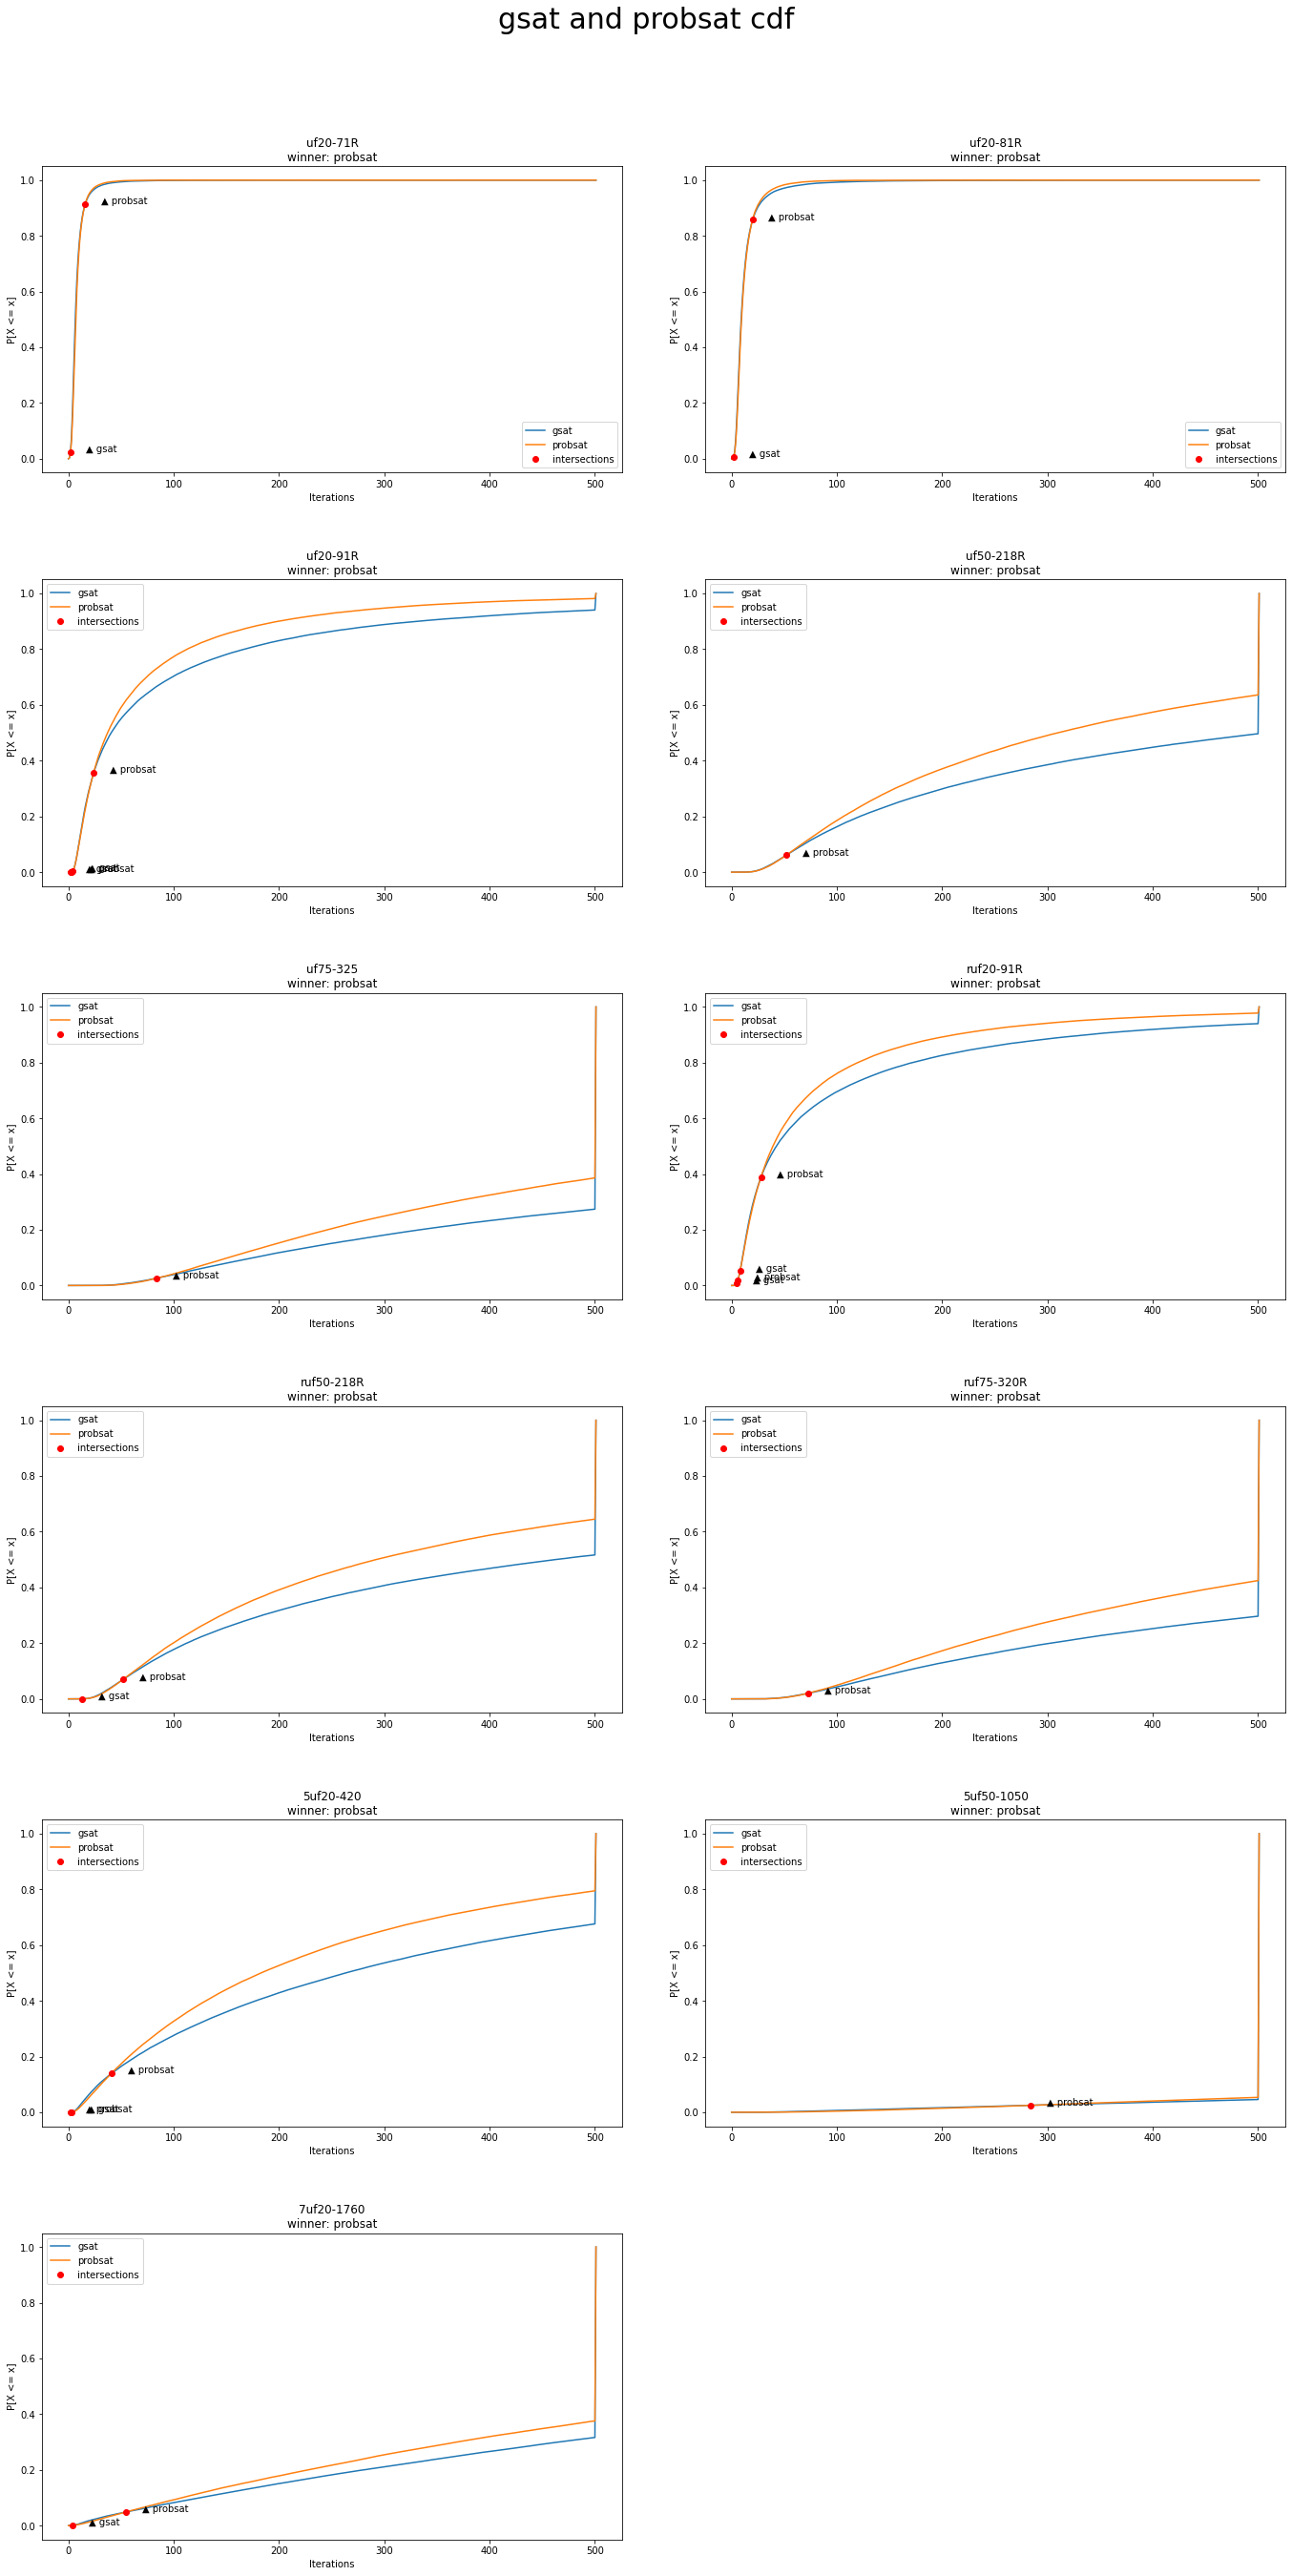

In [25]:
plot_suites_cdf(suites_cdf_dataset)

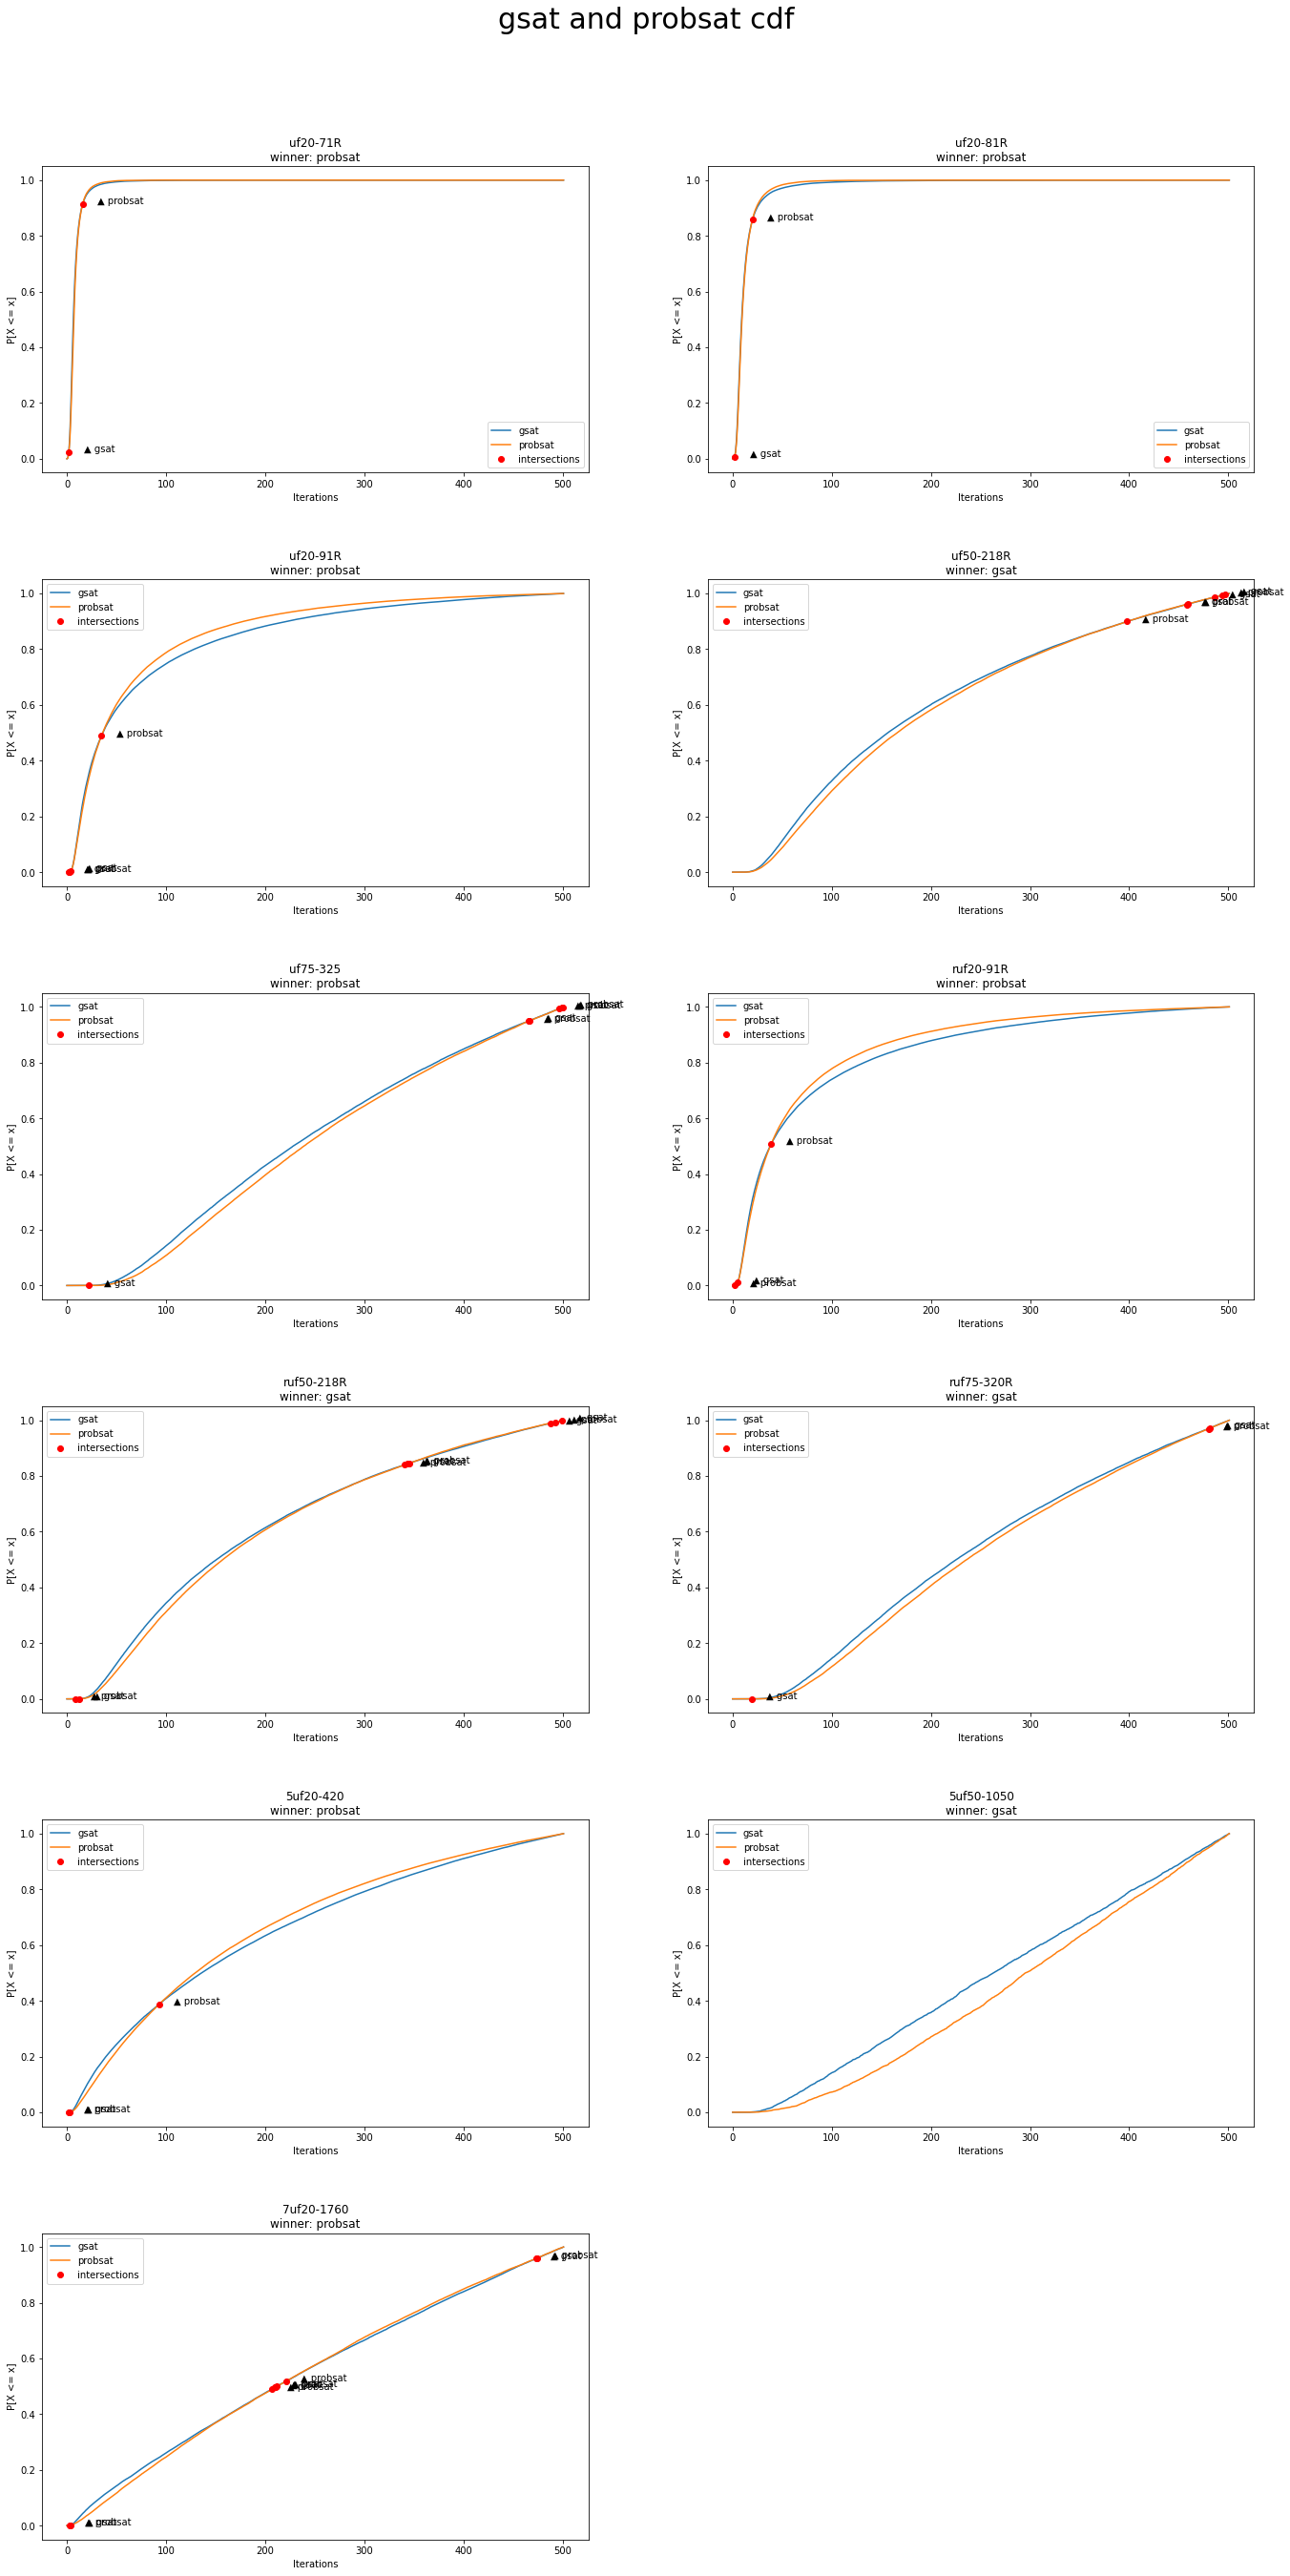

In [26]:
plot_suites_cdf(success_suites_cdf_dataset)

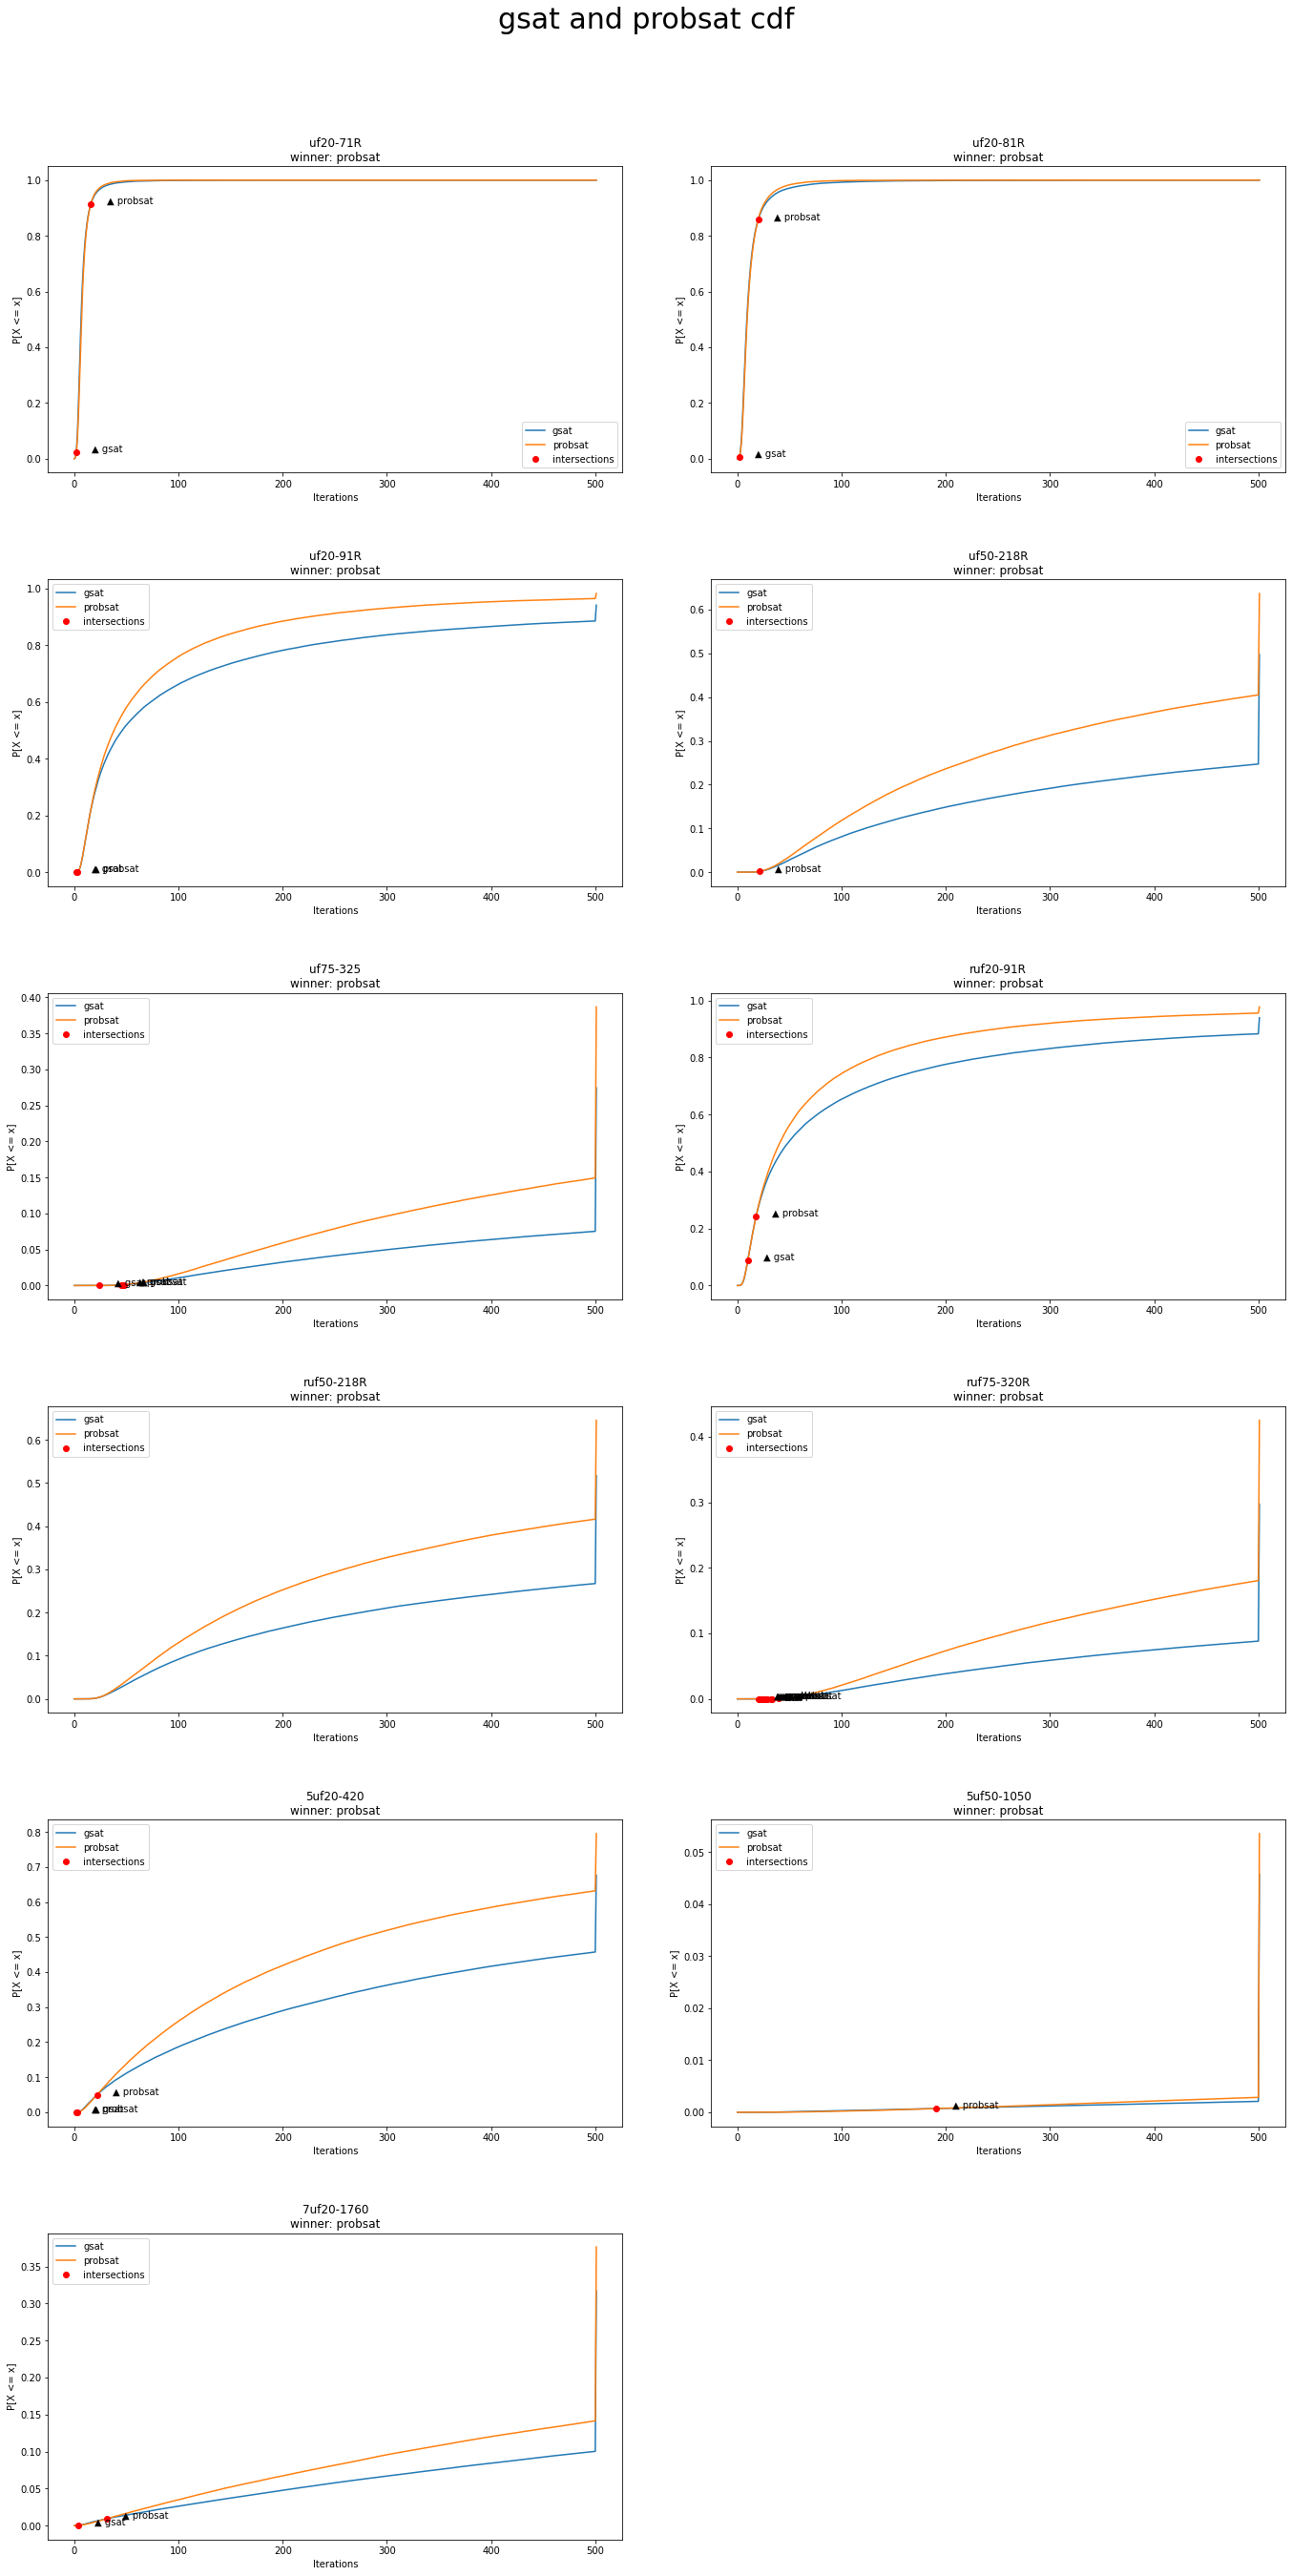

In [27]:
plot_suites_cdf(suites_revcdf_dataset)

In [29]:
def plot_suites_pdf(suites_pdf_dataset, suptitle="gsat and probsat cdf"):
  fig, axes = plt.subplots(math.ceil(len(suites_cdf_dataset) / 2), 2, figsize=(20, 40))

  if len(suites_cdf_dataset) % 2 != 0:
      for l in axes[int(len(suites_cdf_dataset) / 2 - 1), 1].get_xaxis().get_majorticklabels():
          l.set_visible(True)
      fig.delaxes(axes[int(len(suites_cdf_dataset) / 2), 1])

  for i, suite in enumerate(suites_cdf_dataset):
    cdf_gsat = suites_cdf_dataset[suite]['cdf_gsat']
    cdf_probsat = suites_cdf_dataset[suite]['cdf_probsat']
    
    ax = axes[int(i / 2), i % 2]

    

    ax.set_title(f'{suite}\nwinner: {winner}')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('P[X <= x]')
    ax.legend()

  fig.suptitle(suptitle, fontsize=30)
  fig.tight_layout(pad=5, rect=[0, 0.03, 1, 0.95])
  fig.show()

In [30]:
# suites_cdf_dataset = {}
# for suite in DATA_SUITES:
#     gsat, probsat = load_datasets(suite)
#     cdf_gsat = cdf(gsat)
#     cdf_probsat = cdf(probsat)
#     suites_cdf_dataset[suite] = {
#         'cdf_gsat': cdf_gsat,
#         'cdf_probsat': cdf_probsat,
#         'cdf_xings': xings(cdf_gsat, cdf_probsat)
#     }

# success_suites_pdf_dataset = {}
# for suite in DATA_SUITES:
#     gsat, probsat = load_datasets(suite)
#     cdf_gsat = cdf(success_runs(gsat))
#     cdf_probsat = cdf(success_runs(probsat))
#     success_suites_cdf_dataset[suite] = {
#         'cdf_gsat': cdf_gsat,
#         'cdf_probsat': cdf_probsat,
#         'cdf_xings': xings(cdf_gsat, cdf_probsat)
#     }


In [34]:
def pdf(x, sigma, mu):
  return (1/(x*sigma*math.sqrt(2*math.pi))) * math.exp(-((math.log(x) - mu) ** 2) / (2 * sigma ** 2))

In [44]:
suites_lognormal_dataset = {}
for suite in DATA_SUITES:
    gsat, probsat = load_datasets(suite)

    gsat = success_runs(gsat)
    probsat = success_runs(probsat)

    iterations_gsat = gsat['iterations'].replace(0, sys.float_info.min).sort_values(ignore_index=True)
    iterations_probsat = probsat['iterations'].replace(0, sys.float_info.min).sort_values(ignore_index=True)

    mu_gsat = lognormal_mu(gsat)
    sigma_gsat = lognormal_sigma(gsat)

    mu_probsat = lognormal_mu(probsat)
    sigma_probsat = lognormal_sigma(probsat)

    pdf_data_gsat = [pdf(x, sigma_gsat, mu_gsat) for x in range(1, max_iterations)]
    pdf_data_probsat = [pdf(x, sigma_probsat, mu_probsat) for x in range(1, max_iterations)]

    suites_lognormal_dataset[suite] = {
        'iterations_gsat': iterations_gsat,
        'iterations_probsat': iterations_probsat,
        'pdf_data_gsat': pdf_data_gsat,
        'pdf_data_probsat': pdf_data_probsat
    }

In [51]:
def plot_suites_lognormal(suites_lognormal_dataset, suptitle="gsat and probsat lognormal"):
  fig, axes = plt.subplots(len(suites_lognormal_dataset), 2, figsize=(20, 40))

  for i, suite in enumerate(suites_lognormal_dataset):
    iterations_gsat = suites_lognormal_dataset[suite]['iterations_gsat']
    iterations_probsat = suites_lognormal_dataset[suite]['iterations_probsat']

    pdf_data_gsat = suites_lognormal_dataset[suite]['pdf_data_gsat']
    pdf_data_probsat = suites_lognormal_dataset[suite]['pdf_data_probsat']
    
    ax = axes[i, 0]

    gsat_ax = sns.histplot(data=iterations_gsat, stat='density', ax=ax)
    gsat_ax.plot(pdf_data_gsat, 'r-')

    ax.set_title(f'{suite}\ngsat')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Density')

    ax = axes[i, 1]

    probsat_ax = sns.histplot(data=iterations_probsat, stat='density', ax=ax)
    probsat_ax.plot(pdf_data_probsat, 'r-')

    ax.set_title(f'{suite}\nprobsat')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Density')

  fig.suptitle(suptitle, fontsize=30)
  fig.tight_layout(pad=5, rect=[0, 0.03, 1, 0.95])
  fig.show()

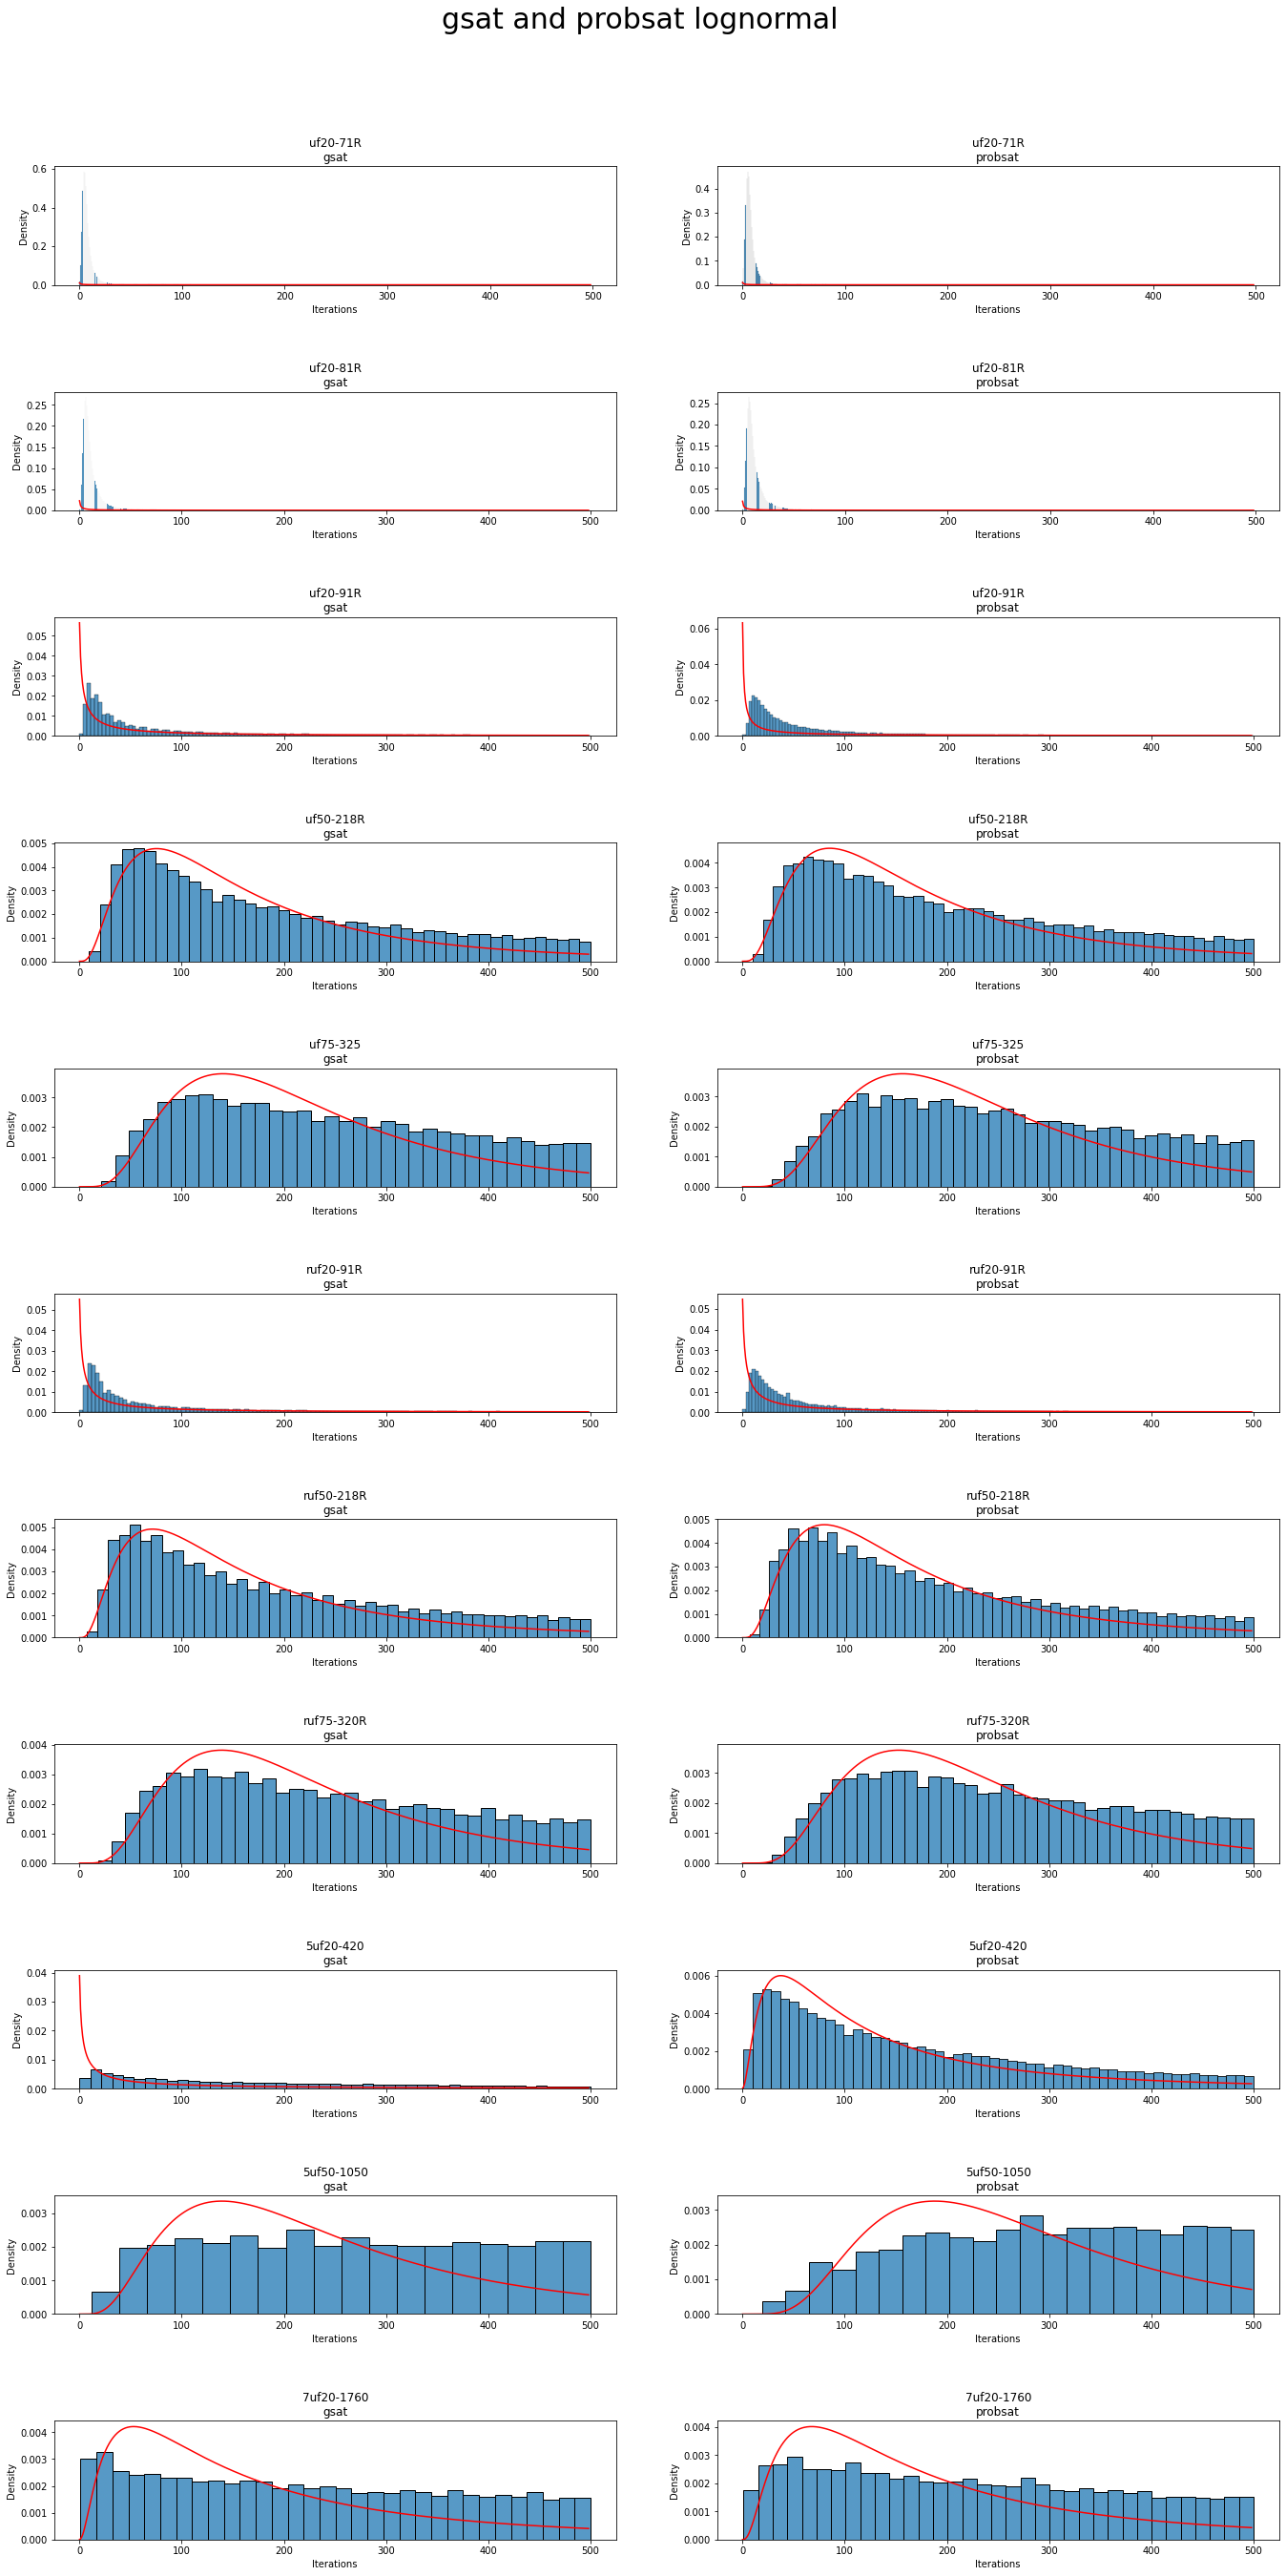

In [52]:
plot_suites_lognormal(suites_lognormal_dataset)